# Multiclass Classification & Multilabel & Multioutput

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
X, y = digits["data"], digits['target']
X.shape

(1797, 64)

In [4]:
y.shape

(1797,)

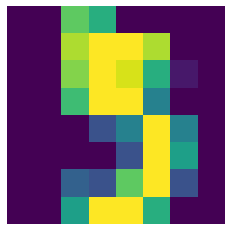

In [5]:
some_digit = X[5]
some_digit_image = some_digit.reshape(8, 8)
plt.imshow(some_digit_image)
plt.axis("off")
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [7]:
X_train.shape

(1527, 64)

In [8]:
X_test.shape

(270, 64)

## Multiclass Classification

Whereas binary classifies distinguish between two classes, multiclass classifiers can distinguish between more than two classes.

Some algorithms (such as Logistic Regression classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handing multiple classes natively. Others (such as SGD classifiers or Support Vector Machine classifiers) are strictly binary classifiers. However, ther are vaious strategies that you can use to perform multiclass classification with multiple binary classifiers.

* OvR: one-versus-the-rest
* OvO: one-versus-one

Scikit-Learn detects when you try to use a binary classification algorithm for multiclass classification task, and it automatically runs OvR or OvO depending on the algorithm.

#### Multi class Logistic Regression Using OvR

In [9]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class = 'ovr', solver = 'liblinear')
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.9666666666666667

#### Using Support Vector Machine

In [10]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.score(X_test, y_test)

0.9888888888888889

Under the hood, Scikit-Learn actually used the OvO strategy: it traied 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

In [11]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.73437497,  5.18795566,  3.73372684,  8.27971482,  0.72473061,
         7.27966061,  1.71630801, -0.28648988,  6.25223905,  9.30198943]])

The highest score is indeed the one corresponding to class 5:

In [12]:
np.argmax(some_digit_scores)

9

#### Using Support Vector Machine with OvR

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the OneVsOneClassifier or OneVsRestClassifier classes.

In [13]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([9])

#### Using SGDClassifier

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([9])

In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.95284872, 0.94891945, 0.93123772])

To increse accurcy, we use StandardScaler()

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.94695481, 0.9410609 , 0.93123772])

## Error Analysis

* Confusion matrix is a great tool to pin-point where our classifier is going wrong
* It is a grid and will help us understand exactly which digits our classifier get wrong

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[153,   0,   0,   0,   0,   0,   0,   0,   2,   0],
       [  0, 150,   0,   1,   0,   0,   0,   0,  10,   3],
       [  0,   2, 142,   2,   1,   0,   0,   0,   4,   0],
       [  0,   0,   0, 141,   0,   2,   0,   3,   9,   4],
       [  1,   1,   0,   0, 133,   0,   3,   1,   4,   1],
       [  0,   0,   0,   1,   0, 141,   0,   2,   3,   2],
       [  0,   1,   0,   0,   0,   0, 146,   0,   4,   0],
       [  0,   0,   0,   1,   2,   0,   0, 146,   3,   1],
       [  0,   6,   0,   1,   0,   0,   0,   0, 148,   0],
       [  0,   2,   0,   3,   0,   2,   0,   2,   5, 132]])

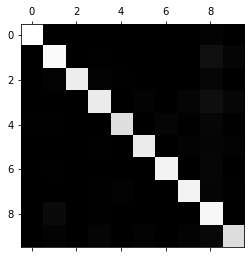

In [18]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

* Rows are actual classes
* Columns are predicted classes
* We are not seeing the errors yet
* Here more gray means more error possibly

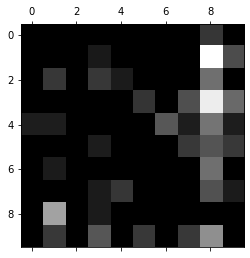

In [19]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums # to normalize the matrix
np.fill_diagonal(norm_conf_mx, 0) # to see only errors

plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

* Diagonal is pitch black as we wanted
* Brighter colors represent larger errors
* See columns 8 , lot of bright pathes. This means many digits are misclassified as 8.

## Multilabel classification

Difference between multi-class classification & multi-label classification is that in multi-class problems the classes are mutually exclusive, whereas for multi-label problems each label represents a different clssification, but the tasks are somehow related.

For example, multi-class classification makes the assumption that each sample is assigned to one and only one label: a furit can be either an apple or a pear but not both at the same time. Whereas, an instance of multi-label classification can be that a text might be about any of religion, politics, finance or education at the same time or none of these.

In [20]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 0)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [21]:
knn_clf.predict([some_digit])

array([[ True, False]])

In [22]:
from sklearn.metrics import f1_score

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.9813994320257357

## Multioutput classification

It is simply a generalizaion of multilabel classification where each label can be multiclass.

In [23]:
noise = np.random.randint(0, 100, (len(X_train), 64))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 64))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [24]:
import matplotlib as mpl

def plot_digit(data):
    image = data.reshape(8, 8)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

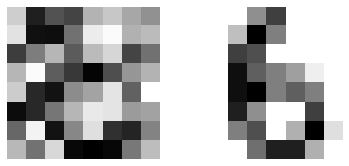

In [25]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

On the left is the noisy input image, and on the right is the clean target image.

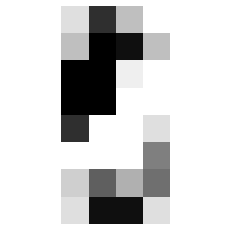

In [26]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)